In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install farasapy keras-self-attention

In [6]:
import pandas as pd

arabic_data = pd.read_excel('/content/drive/MyDrive/Freelancing/project 11/uploaded-dataset/articles.xlsx',nrows=10000)
arabic_data = arabic_data[["articles","summary"]]
arabic_data.head()

,articles,summary
0,و هو يعتبر متحف جديد العهد ، يقدم مجموعة من ال...,المتحف العربي للفن الحديث
1,يعتبر فيلاجيو مول من أهم المجمعات التجارية و أ...,فيلاجيو مول
2,هو المنطقة البحرية الممتدة على مجموعة كيلومترا...,كورنيش الدوحة
3,يعتبر هذا المنتجع من أجمل الأماكن الساحلية الم...,منتجع شاطئ سيلين
4,و هو منتجع مطل على البحر ، و يحوي العديد من أم...,منتجع الغارية


In [7]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [8]:
from preprocessing import ArCleanText

In [9]:
ar_clean = ArCleanText()
ar_clean.arabic_preprocessing("المتحف العربي للفن الحديث")

100%|██████████| 241M/241M [00:24<00:00, 11.2MiB/s]

[2021-05-21 18:56:11,920 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


'متحف عربي فن حديث'

In [10]:
arabic_data.head()

,articles,summary
0,و هو يعتبر متحف جديد العهد ، يقدم مجموعة من العروض الفنية و التشكيلية المتنوعة ، يظهر فنانين عرب معاصرين و تبرز إبداعاتهم الفريدة ، كما أنه يبرز الرؤية العربية عن الفن المعاصر و الفن الحديث العالم...,المتحف العربي للفن الحديث
1,يعتبر فيلاجيو مول من أهم المجمعات التجارية و أشدها جمالا في العالم العربي ، و ذلك لأنه تم بناؤه و تصميمه على هيئة مدينة البندقية الموجودة في إيطاليا ، و هذا ما جعله أمر شيق لكل أفراد العائلة ، و ل...,فيلاجيو مول
2,هو المنطقة البحرية الممتدة على مجموعة كيلومترات بشكل طولي على خليج الدوحة ؛ حيث تطل على الكورنيش مجموعة من المعالم المهمة ، مثل : متحف الفن الإسلامي ، وحديقة الرميلة و فندق الشيراتون الموجود على ه...,كورنيش الدوحة
3,يعتبر هذا المنتجع من أجمل الأماكن الساحلية المطلة على البحر ، حيث يحوي العديد من وسائل الترفيه و الراحة مثل : الشاليهات ، وبرك السباحة ، و المرافق و الخدمات العامة بكافة أنواعها ، أماكن ممارسة الر...,منتجع شاطئ سيلين
4,و هو منتجع مطل على البحر ، و يحوي العديد من أماكن التنزه ، و يتميز بوفرة الشقق السكنية ، أخذ اسمه تبعا من المنطقة الموجود بها .,منتجع الغارية


In [11]:
arabic_data['articles'][:10]

0    و هو يعتبر متحف جديد العهد ، يقدم مجموعة من العروض الفنية و التشكيلية المتنوعة ، يظهر فنانين عرب معاصرين و تبرز إبداعاتهم الفريدة ، كما أنه يبرز الرؤية العربية عن الفن المعاصر و الفن الحديث العالم...
1    يعتبر فيلاجيو مول من أهم المجمعات التجارية و أشدها جمالا في العالم العربي ، و ذلك لأنه تم بناؤه و تصميمه على هيئة مدينة البندقية الموجودة في إيطاليا ، و هذا ما جعله أمر شيق لكل أفراد العائلة ، و ل...
2    هو المنطقة البحرية الممتدة على مجموعة كيلومترات بشكل طولي على خليج الدوحة ؛ حيث تطل على الكورنيش مجموعة من المعالم المهمة ، مثل : متحف الفن الإسلامي ، وحديقة الرميلة و فندق الشيراتون الموجود على ه...
3    يعتبر هذا المنتجع من أجمل الأماكن الساحلية المطلة على البحر ، حيث يحوي العديد من وسائل الترفيه و الراحة مثل : الشاليهات ، وبرك السباحة ، و المرافق و الخدمات العامة بكافة أنواعها ، أماكن ممارسة الر...
4                                                                           و هو منتجع مطل على البحر ، و يحوي العديد من أماكن التنزه ، و يتميز بوفرة الشقق السكنية ، أخذ اسمه تبعا م

In [12]:
cleaned_text = []
for t in arabic_data['articles']:
    cleaned_text.append(ar_clean.arabic_preprocessing(t))

100%|██████████| 241M/241M [00:39<00:00, 11.2MiB/s]

In [13]:
arabic_data['summary'][:10]

0    المتحف العربي للفن الحديث
1                  فيلاجيو مول
2                كورنيش الدوحة
3             منتجع شاطئ سيلين
4                منتجع الغارية
5                  جزيرة النخل
6             مملكة علاء الدين
7         شواطيء الخور و فويرط
8           الجغرافيا و المناخ
9          عدد و تركيبة السكان
Name: summary, dtype: object

In [14]:

#Call the above function
cleaned_summary = []
for t in arabic_data['summary']:
    cleaned_summary.append(ar_clean.arabic_preprocessing(t))

arabic_data['cleaned_text']=cleaned_text
arabic_data['cleaned_summary']=cleaned_summary
arabic_data['cleaned_summary'].replace('', np.nan, inplace=True)
arabic_data.dropna(axis=0,inplace=True)

In [15]:
arabic_data.head()

,articles,summary,cleaned_text,cleaned_summary
0,و هو يعتبر متحف جديد العهد ، يقدم مجموعة من العروض الفنية و التشكيلية المتنوعة ، يظهر فنانين عرب معاصرين و تبرز إبداعاتهم الفريدة ، كما أنه يبرز الرؤية العربية عن الفن المعاصر و الفن الحديث العالم...,المتحف العربي للفن الحديث,اعتبر متحف جديد عهد قدم مجموع عرض فنيه تشكيليه متنوعه ظهر فنان عرب معاصر برز ابداع فريده برز رءيه عربيه فن معاصر فن حديث عالمي عد أبرز متحف عالم جذب متحف كثير سائح محلي عالمي يءهل لان معلم سياحي ث...,متحف عربي فن حديث
1,يعتبر فيلاجيو مول من أهم المجمعات التجارية و أشدها جمالا في العالم العربي ، و ذلك لأنه تم بناؤه و تصميمه على هيئة مدينة البندقية الموجودة في إيطاليا ، و هذا ما جعله أمر شيق لكل أفراد العائلة ، و ل...,فيلاجيو مول,اعتبر فيلاجيو مول أهم مجمع تجاريه اشد جمال عالم عربي لان بناء تصميم هيء مدين بندقيه موجود ايطاليا جعل أمر شيق كل أفراد عاءله سائح أحب شراء أهم مارك العالميه في خص تصميم أزياء شمل فيلاجيو مول أماكن...,فيلاجيو مول
2,هو المنطقة البحرية الممتدة على مجموعة كيلومترات بشكل طولي على خليج الدوحة ؛ حيث تطل على الكورنيش مجموعة من المعالم المهمة ، مثل : متحف الفن الإسلامي ، وحديقة الرميلة و فندق الشيراتون الموجود على ه...,كورنيش الدوحة,منطق بحريه ممتده مجموع كيلومتر طول خليج دوحه أطل كرنيش مجموع معلم مهمه متحف فن إسلامي حديق رميله فندق شيراتون موجود هيء هرم اضافه مجموع وزارة هيء لجنه اولمبيه قطريه مجلس اعلي اتصال تكنولوجيا معلوم...,كرنيش دوحه
3,يعتبر هذا المنتجع من أجمل الأماكن الساحلية المطلة على البحر ، حيث يحوي العديد من وسائل الترفيه و الراحة مثل : الشاليهات ، وبرك السباحة ، و المرافق و الخدمات العامة بكافة أنواعها ، أماكن ممارسة الر...,منتجع شاطئ سيلين,اعتبر منتجع أجمل مكان ساحليه مطله بحر حوى عديد ساءل ترفيه راحه شاليه برك سباحه مرفق خدمة عام كاف انواع أماكن ممارس رياضة بحريه غير تميز موقع منتج قرب عاصمه بعد مساف ساعي سياره,منتجع شاطء سيل
4,و هو منتجع مطل على البحر ، و يحوي العديد من أماكن التنزه ، و يتميز بوفرة الشقق السكنية ، أخذ اسمه تبعا من المنطقة الموجود بها .,منتجع الغارية,منتجع مطل بحر حوى عديد أماكن تنزه تميز وفر شقة سكنيه أخذ اسم تبع منطق موجود,منتجع غاريه


In [16]:
arabic_data['cleaned_summary'] = arabic_data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')


In [17]:
for i in range(5):
    print("Review:",arabic_data['cleaned_text'][i])
    print("Summary:",arabic_data['cleaned_summary'][i])
    print("\n")

Review: اعتبر متحف جديد عهد قدم مجموع عرض فنيه تشكيليه متنوعه ظهر فنان عرب معاصر برز ابداع فريده برز رءيه عربيه فن معاصر فن حديث عالمي عد أبرز متحف عالم جذب متحف كثير سائح محلي عالمي يءهل لان معلم سياحي ثقافي طراز أول اعتبر زيارة ضروري كل سائح موجود مدين دوحه
Summary: _START_ متحف عربي فن حديث _END_


Review: اعتبر فيلاجيو مول أهم مجمع تجاريه اشد جمال عالم عربي لان بناء تصميم هيء مدين بندقيه موجود ايطاليا جعل أمر شيق كل أفراد عاءله سائح أحب شراء أهم مارك العالميه في خص تصميم أزياء شمل فيلاجيو مول أماكن سمح ركوب قارب جندول راءعه استخدام تنقل كامل مول خلال نهر جرى وسط نهاي مطاف نصح ذهاب مطعم العالميه راءعه موجود
Summary: _START_ فيلاجيو مول _END_


Review: منطق بحريه ممتده مجموع كيلومتر طول خليج دوحه أطل كرنيش مجموع معلم مهمه متحف فن إسلامي حديق رميله فندق شيراتون موجود هيء هرم اضافه مجموع وزارة هيء لجنه اولمبيه قطريه مجلس اعلي اتصال تكنولوجيا معلومة استطاع سائح فعل أمور كثير كرنيش شرب مشروب قهوه شاي مشروب كرك عبار شاي احمر أضاف قليل حليب
Summary: _START_ كرنيش دوحه _END_


Review: اعتبر

In [18]:
len(arabic_data['cleaned_text'].iloc[2])

287

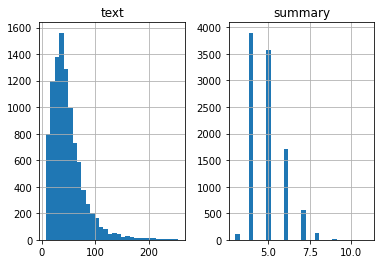

In [19]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in arabic_data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in arabic_data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [20]:
max_len_text=100
max_len_summary=10

arabic_data.head()

,articles,summary,cleaned_text,cleaned_summary
0,و هو يعتبر متحف جديد العهد ، يقدم مجموعة من العروض الفنية و التشكيلية المتنوعة ، يظهر فنانين عرب معاصرين و تبرز إبداعاتهم الفريدة ، كما أنه يبرز الرؤية العربية عن الفن المعاصر و الفن الحديث العالم...,المتحف العربي للفن الحديث,اعتبر متحف جديد عهد قدم مجموع عرض فنيه تشكيليه متنوعه ظهر فنان عرب معاصر برز ابداع فريده برز رءيه عربيه فن معاصر فن حديث عالمي عد أبرز متحف عالم جذب متحف كثير سائح محلي عالمي يءهل لان معلم سياحي ث...,_START_ متحف عربي فن حديث _END_
1,يعتبر فيلاجيو مول من أهم المجمعات التجارية و أشدها جمالا في العالم العربي ، و ذلك لأنه تم بناؤه و تصميمه على هيئة مدينة البندقية الموجودة في إيطاليا ، و هذا ما جعله أمر شيق لكل أفراد العائلة ، و ل...,فيلاجيو مول,اعتبر فيلاجيو مول أهم مجمع تجاريه اشد جمال عالم عربي لان بناء تصميم هيء مدين بندقيه موجود ايطاليا جعل أمر شيق كل أفراد عاءله سائح أحب شراء أهم مارك العالميه في خص تصميم أزياء شمل فيلاجيو مول أماكن...,_START_ فيلاجيو مول _END_
2,هو المنطقة البحرية الممتدة على مجموعة كيلومترات بشكل طولي على خليج الدوحة ؛ حيث تطل على الكورنيش مجموعة من المعالم المهمة ، مثل : متحف الفن الإسلامي ، وحديقة الرميلة و فندق الشيراتون الموجود على ه...,كورنيش الدوحة,منطق بحريه ممتده مجموع كيلومتر طول خليج دوحه أطل كرنيش مجموع معلم مهمه متحف فن إسلامي حديق رميله فندق شيراتون موجود هيء هرم اضافه مجموع وزارة هيء لجنه اولمبيه قطريه مجلس اعلي اتصال تكنولوجيا معلوم...,_START_ كرنيش دوحه _END_
3,يعتبر هذا المنتجع من أجمل الأماكن الساحلية المطلة على البحر ، حيث يحوي العديد من وسائل الترفيه و الراحة مثل : الشاليهات ، وبرك السباحة ، و المرافق و الخدمات العامة بكافة أنواعها ، أماكن ممارسة الر...,منتجع شاطئ سيلين,اعتبر منتجع أجمل مكان ساحليه مطله بحر حوى عديد ساءل ترفيه راحه شاليه برك سباحه مرفق خدمة عام كاف انواع أماكن ممارس رياضة بحريه غير تميز موقع منتج قرب عاصمه بعد مساف ساعي سياره,_START_ منتجع شاطء سيل _END_
4,و هو منتجع مطل على البحر ، و يحوي العديد من أماكن التنزه ، و يتميز بوفرة الشقق السكنية ، أخذ اسمه تبعا من المنطقة الموجود بها .,منتجع الغارية,منتجع مطل بحر حوى عديد أماكن تنزه تميز وفر شقة سكنيه أخذ اسم تبع منطق موجود,_START_ منتجع غاريه _END_


In [21]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(arabic_data['cleaned_text'],arabic_data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 


In [22]:
x_tr[1]

'اعتبر فيلاجيو مول أهم مجمع تجاريه اشد جمال عالم عربي لان بناء تصميم هيء مدين بندقيه موجود ايطاليا جعل أمر شيق كل أفراد عاءله سائح أحب شراء أهم مارك العالميه في خص تصميم أزياء شمل فيلاجيو مول أماكن سمح ركوب قارب جندول راءعه استخدام تنقل كامل مول خلال نهر جرى وسط نهاي مطاف نصح ذهاب مطعم العالميه راءعه موجود'

In [23]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

% of rare words in vocabulary: 59.101548433561405
Total Coverage of rare words: 4.3658904878969516
9087


In [24]:
x_tr.shape

(8997, 100)

In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

# y_tokenizer.word_counts['_START_'],len(y_tr)

% of rare words in vocabulary: 80.73447413958854
Total Coverage of rare words: 18.123152598208446


In [26]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [27]:
x_val.shape

(899, 100)

In [28]:
x_tr.shape

(8340, 100)

In [29]:
from keras import backend as K 
K.clear_session()
# max_len_text=80 
# max_len_summary=15
latent_dim = 200
embedding_dim=300

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
print(encoder_inputs)
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
# attn_layer = AttentionLayer(name='attention_layer')
# attn_out = attn_layer([encoder_outputs, decoder_outputs])

# # Concat attention input and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     2726100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 200), ( 400800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]  

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],
                  batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
66/66 [==============================] - 85s 1s/step - loss: 2.8877 - val_loss: 1.6503
Epoch 2/50
15/66 [=====>........................] - ETA: 56s - loss: 1.7344

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# **Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

# **We are defining a function below which is the implementation of the inference process**

In [ ]:
with open('/content/drive/MyDrive/Freelancing/project 11/encoder_model.json', 'w', encoding='utf8') as f:
    f.write(encoder_model.to_json())
encoder_model.save_weights('/content/drive/MyDrive/Freelancing/project 11/encoder_model_weights.h5')

In [ ]:
with open('/content/drive/MyDrive/Freelancing/project 11/decoder_model.json', 'w', encoding='utf8') as f:
    f.write(decoder_model.to_json())
decoder_model.save_weights('/content/drive/MyDrive/Freelancing/project 11/decoder_model_weights.h5')

In [ ]:
from keras.models import  model_from_json
def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read())
    model.load_weights(model_weights_filename)
    return model

encoder_testing = load_model('/content/drive/MyDrive/Freelancing/project 11/encoder_model.json', '/content/drive/MyDrive/Freelancing/project 11/encoder_model_weights.h5')
decoder_testing = load_model('/content/drive/MyDrive/Freelancing/project 11/decoder_model.json','/content/drive/MyDrive/Freelancing/project 11/decoder_model_weights.h5')

In [ ]:
print(encoder_testing)
print(decoder_testing)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    print(input_seq.shape)
    e_out, e_h, e_c = encoder_testing.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_testing.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    
    return newString

In [ ]:
for i in range(0,5):
    print("Review:",seq2text(x_tr[i]))
    #print("Original summary:",seq2summary(y_tr[i]))
    # print(x_tr[i].shape)
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
    print("\n")